In [1]:
dataset_name = "international-airline-passengers"
path = "data/" + dataset_name + ".csv"
gaussian_window_size=100

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '1MS', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '1MS', data, method="linear")

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="1MS", 
                                          dateformat="%Y-%m", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["1957-05"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  1949-01
End date:  1960-12
Missing time stamps: 
 DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
Fill Missing Time Steps with Interpolation
Length:  144
Time step size:  1MS
Start Date:  1949-01
End Date:  1960-12
Date Format:  %Y-%m
True outlier indices:  [100]


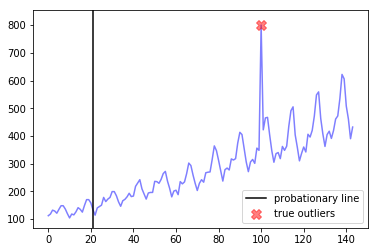

In [4]:
ad.plot_outliers([], true_outlier_indices)

# SARIMA: using autoarima

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=184.554, BIC=186.643, Fit time=0.015 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=170.647, BIC=173.781, Fit time=0.011 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 24); AIC=167.570, BIC=171.748, Fit time=0.018 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 24); AIC=171.250, BIC=177.517, Fit time=0.032 seconds


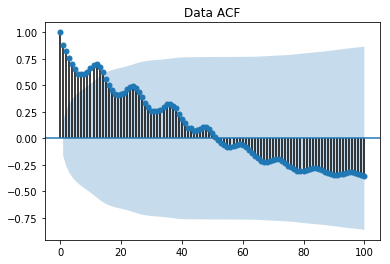

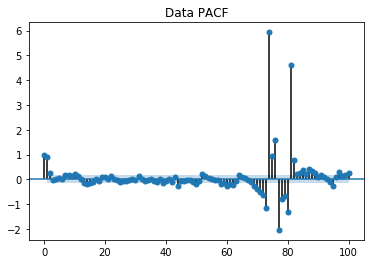

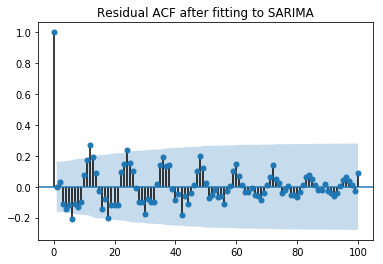

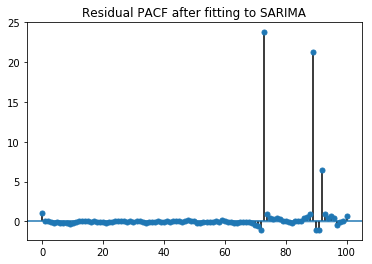

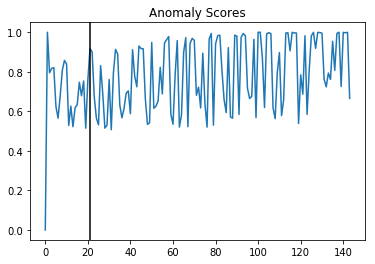

Time:  0.37311315536499023
RMSE:  57.50091516207105


['anomaly_scores/SARIMA_auto/international-airline-passengers']

In [5]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,
                        autoarima=True, 
                        autoarima_season=True, 
                        s = 24,
                        plot_acf=True, 
                        maxiter=3, 
                        plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


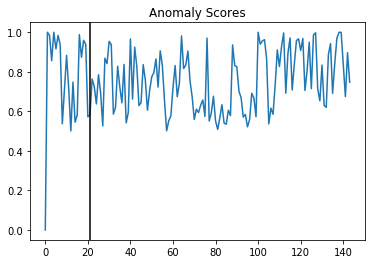

Time:  1.6575589179992676
RMSE:  42.59161786021094


['anomaly_scores/Prophet/international-airline-passengers']

In [6]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size,periods=0, daily_seasonality=True, interval_width=.999, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# RNN

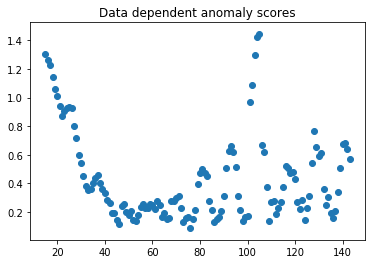

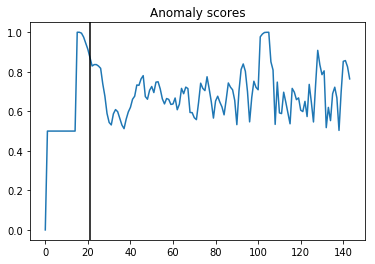

Time:  4.379656076431274


['anomaly_scores/RNN/international-airline-passengers']

In [5]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=10, n_seq=5, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

In [8]:
save_path = "anomaly_scores/Twitter/" + dataset_name
output_dict = ad.twitterad(period=12,max_anoms=2/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

R twitterad completed: True
Time:  0.12970924377441406


['anomaly_scores/Twitter/international-airline-passengers']

# STL Resid

R stlplus completed:  no missing True


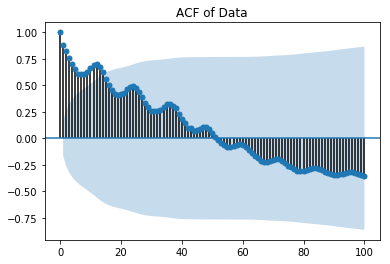

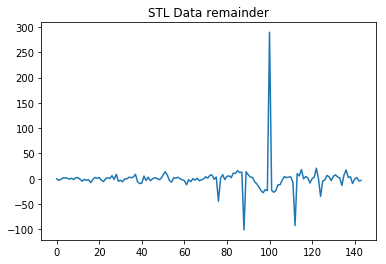

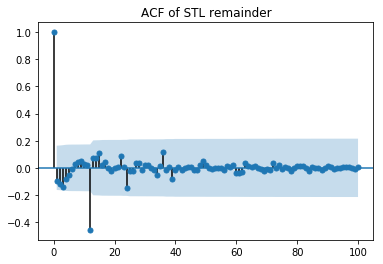

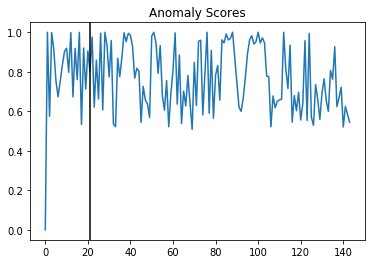

Time:  0.8026435375213623


['anomaly_scores/stl/international-airline-passengers']

In [10]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size,n_periods=12, swindow=7, outer=1, fill_option="linear", plot_resid=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# windowed gaussian

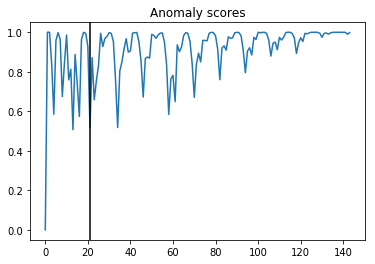

Time:  0.011416912078857422


['anomaly_scores/windowed_gaussian/international-airline-passengers']

In [11]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name
output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size,plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

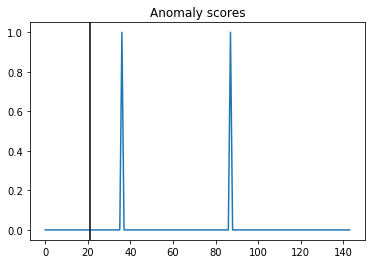

Time:  0.15704655647277832


['anomaly_scores/hotsax/international-airline-passengers']

In [12]:
save_path = "anomaly_scores/hotsax/" + dataset_name
output_dict = ad.hotsax(win_size=50, num_discords=2,
               a_size=3, paa_size=3, z_threshold=0.01,
               plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

In [13]:
# no HTM bc needs at least 400 rows
# no Donut bc not enough points
# no SARIMA: using own params bc noninvertible